In [ ]:
pip install lightning pytorch_forecasting

In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import matplotlib.pyplot as plt

In [2]:
# load the dataset
data = pd.read_csv("Final_DF.csv")

In [3]:
data.head(10)

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,ETH_Price,SOL_Price,XRP_Price
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,158.412445,0.951054,0.187464
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,158.216019,0.776819,0.188063
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,161.142426,0.882507,0.190135
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,156.279556,0.777832,0.187732
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,157.596390,0.661925,0.185335
5,2020-04-15,99.459999,1712.25,0.05,0.635,40.84,6642.109863,153.286896,0.646651,0.181270
6,2020-04-16,100.029999,1717.85,0.05,0.617,40.11,7116.804199,172.157379,0.690816,0.190104
7,2020-04-17,99.779999,1693.15,0.05,0.642,38.15,7096.184570,171.638580,0.660728,0.190202
8,2020-04-18,99.779999,1693.15,0.05,0.642,38.15,7257.665039,186.914001,0.681096,0.194925
9,2020-04-19,99.779999,1693.15,0.05,0.642,38.15,7189.424805,181.614960,0.606969,0.190859


In [4]:
# combine all cryptocurrencies into one column
data = data.melt(
    id_vars=['Date', 'Dollar_Index', 'Gold_Price', 'Interest_Rate', 'US_10_Year', 'VIX_Value'],
    value_vars=['BTC_Price', 'ETH_Price', 'SOL_Price', 'XRP_Price'],
    var_name='currency_type',
    value_name='price_target'
)

# Map group_id to a standard format (optional)
data['currency_type'] = data['currency_type'].str.replace('_Price', '')

# Sort by date and group_id
data = data.sort_values(by=['Date', 'currency_type']).reset_index(drop=True)

# Display the transformed data
print(data.head())

         Date  Dollar_Index  Gold_Price  Interest_Rate  US_10_Year  VIX_Value  \
0  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
1  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
2  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
3  2020-04-10     99.519997      1662.5           0.05       0.729      41.67   
4  2020-04-11     99.519997      1662.5           0.05       0.729      41.67   

  currency_type  price_target  
0           BTC   6865.493164  
1           ETH    158.412445  
2           SOL      0.951054  
3           XRP      0.187464  
4           BTC   6859.083008  


In [5]:
data.head(10)

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,currency_type,price_target
0,2020-04-10,99.519997,1662.5,0.05,0.729,41.67,BTC,6865.493164
1,2020-04-10,99.519997,1662.5,0.05,0.729,41.67,ETH,158.412445
2,2020-04-10,99.519997,1662.5,0.05,0.729,41.67,SOL,0.951054
3,2020-04-10,99.519997,1662.5,0.05,0.729,41.67,XRP,0.187464
4,2020-04-11,99.519997,1662.5,0.05,0.729,41.67,BTC,6859.083008
5,2020-04-11,99.519997,1662.5,0.05,0.729,41.67,ETH,158.216019
6,2020-04-11,99.519997,1662.5,0.05,0.729,41.67,SOL,0.776819
7,2020-04-11,99.519997,1662.5,0.05,0.729,41.67,XRP,0.188063
8,2020-04-12,99.519997,1662.5,0.05,0.729,41.67,BTC,6971.091797
9,2020-04-12,99.519997,1662.5,0.05,0.729,41.67,ETH,161.142426


In [6]:
# convert columns datatypes into appropriate data types
data['Date'] = pd.to_datetime(data['Date'])
data['currency_type'] = data['currency_type'].astype(str).astype("category")

In [7]:
data.dtypes

Date             datetime64[ns]
Dollar_Index            float64
Gold_Price              float64
Interest_Rate           float64
US_10_Year              float64
VIX_Value               float64
currency_type          category
price_target            float64
dtype: object

In [8]:
print(data["Date"].dt.day)

0       10
1       10
2       10
3       10
4       11
        ..
6939     8
6940     9
6941     9
6942     9
6943     9
Name: Date, Length: 6944, dtype: int32


In [14]:
# add the time index
data["time_idx"] = (data["Date"] - data["Date"].min()).dt.days

In [13]:
data.tail(10)

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,currency_type,price_target,month,day_of_week,day_of_year,quarter,log_price
6934,2025-01-07,108.540001,2648.7119,4.33,4.684,17.82,SOL,202.230255,1,1,7,1,5.309407
6935,2025-01-07,108.540001,2648.7119,4.33,4.684,17.82,XRP,2.272350,1,1,7,1,0.820815
6936,2025-01-08,109.089996,2661.5352,4.33,4.692,17.70,BTC,95043.523438,1,2,8,1,11.462090
6937,2025-01-08,109.089996,2661.5352,4.33,4.692,17.70,ETH,3326.329346,1,2,8,1,8.109625
6938,2025-01-08,109.089996,2661.5352,4.33,4.692,17.70,SOL,197.559052,1,2,8,1,5.286038
6939,2025-01-08,109.089996,2661.5352,4.33,4.692,17.70,XRP,2.375305,1,2,8,1,0.865126
6940,2025-01-09,109.180000,2669.9489,4.33,4.688,18.07,BTC,92484.039062,1,3,9,1,11.434791
6941,2025-01-09,109.180000,2669.9489,4.33,4.688,18.07,ETH,3219.430664,1,3,9,1,8.076960
6942,2025-01-09,109.180000,2669.9489,4.33,4.688,18.07,SOL,185.025284,1,3,9,1,5.220492
6943,2025-01-09,109.180000,2669.9489,4.33,4.688,18.07,XRP,2.275212,1,3,9,1,0.822073


In [15]:
# add additional features
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings
data["day_of_week"] = data.Date.dt.dayofweek.astype(str).astype("category")
data["day_of_year"] = data.Date.dt.dayofyear.astype(str).astype("category")
data["quarter"] = data.Date.dt.quarter.astype(str).astype("category")  # categories have be strings

data["log_price"] = np.log(data.price_target + 1e-8)

In [16]:
data.dtypes

Date             datetime64[ns]
Dollar_Index            float64
Gold_Price              float64
Interest_Rate           float64
US_10_Year              float64
VIX_Value               float64
currency_type          category
price_target            float64
month                  category
day_of_week            category
day_of_year            category
quarter                category
log_price               float64
time_idx                  int64
dtype: object

In [17]:
# create the TimeSeriesDataset
max_prediction_length = 30
max_encoder_length = 90
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price_target",
    group_ids=["currency_type"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["currency_type"],
    static_reals=[],
    time_varying_known_categoricals=["month", "day_of_week", "day_of_year", "quarter"],
    time_varying_known_reals=["Dollar_Index", "Gold_Price", "Interest_Rate", "US_10_Year", "VIX_Value"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["price_target","log_price"],
    target_normalizer=GroupNormalizer(
        groups=["currency_type"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# **Find optimal learning rate**

In [18]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    # optimizer="Ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 14.7k


c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 2050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_conne

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.007079457843841384
Restoring states from the checkpoint path at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_d2fcf51b-8015-44dc-ae4c-d9c07d216657.ckpt
Restored all states from the checkpoint at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_d2fcf51b-8015-44dc-ae4c-d9c07d216657.ckpt


suggested learning rate: 0.007079457843841384


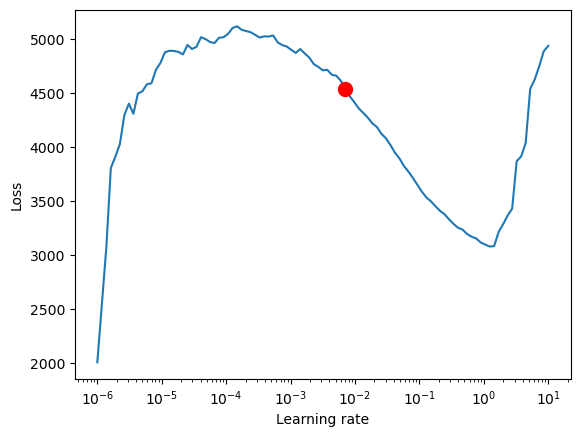

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_23932\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [19]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# **Train the Model**

In [20]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=64,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.007,
    hidden_size=64,
    attention_head_size=8,
    dropout=0.3,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 257.1k


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minim

In [21]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 16.2 K | train
3  | prescalers                         | ModuleDict                      | 176    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.3 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 16.6 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 12.7 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **Evaluate performance**

In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [23]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor(1198.9231, device='cuda:0')

In [24]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


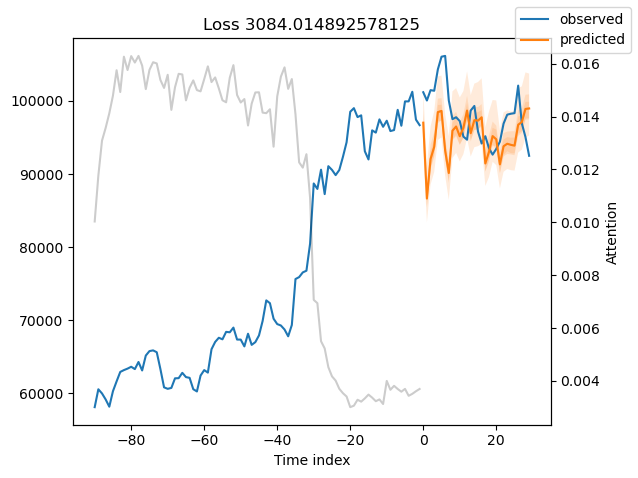

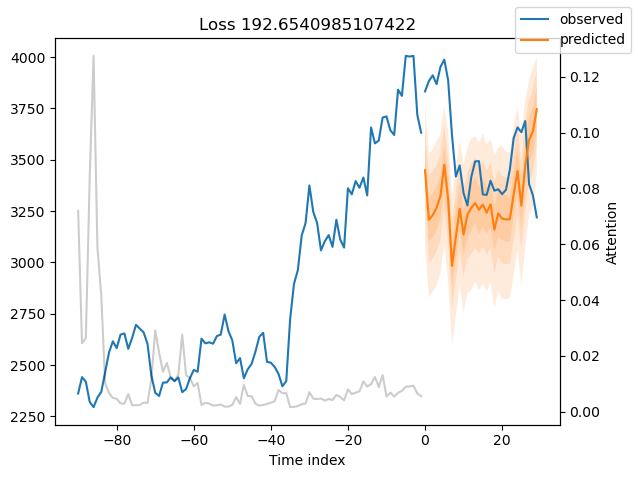

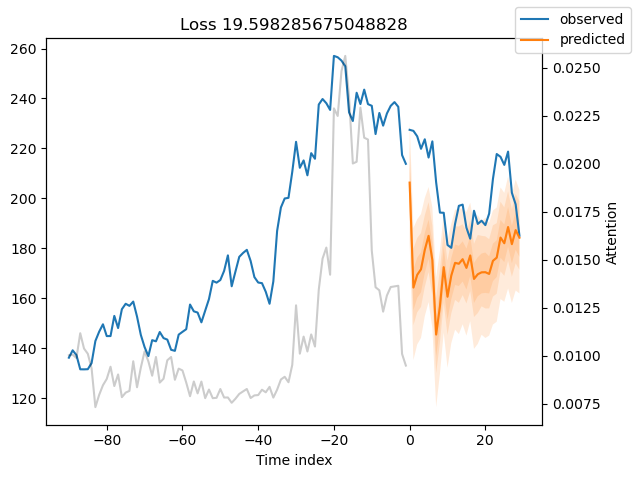

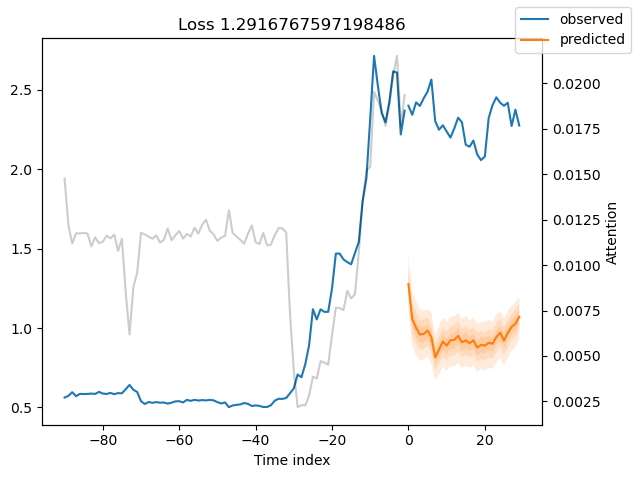

In [25]:
# Access the predictions from the named tuple
predictions_tensor = raw_predictions.output.prediction

# Get the number of available predictions (first dimension of the tensor)
num_predictions = predictions_tensor.size(0)

# Adjust loop to avoid out-of-bounds error
for idx in range(min(10, num_predictions)):  # Only iterate over available predictions
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [26]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 1198.923095703125


In [27]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


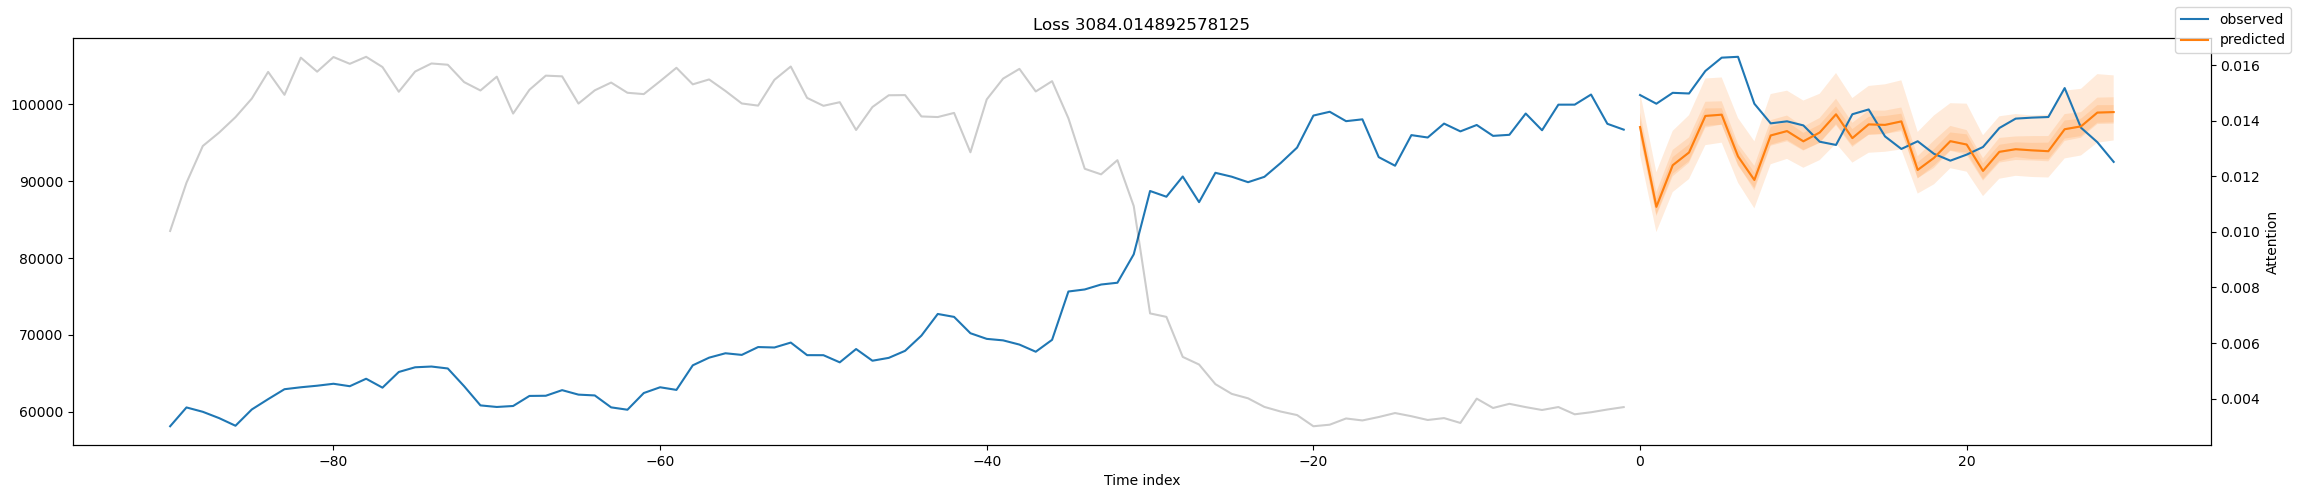

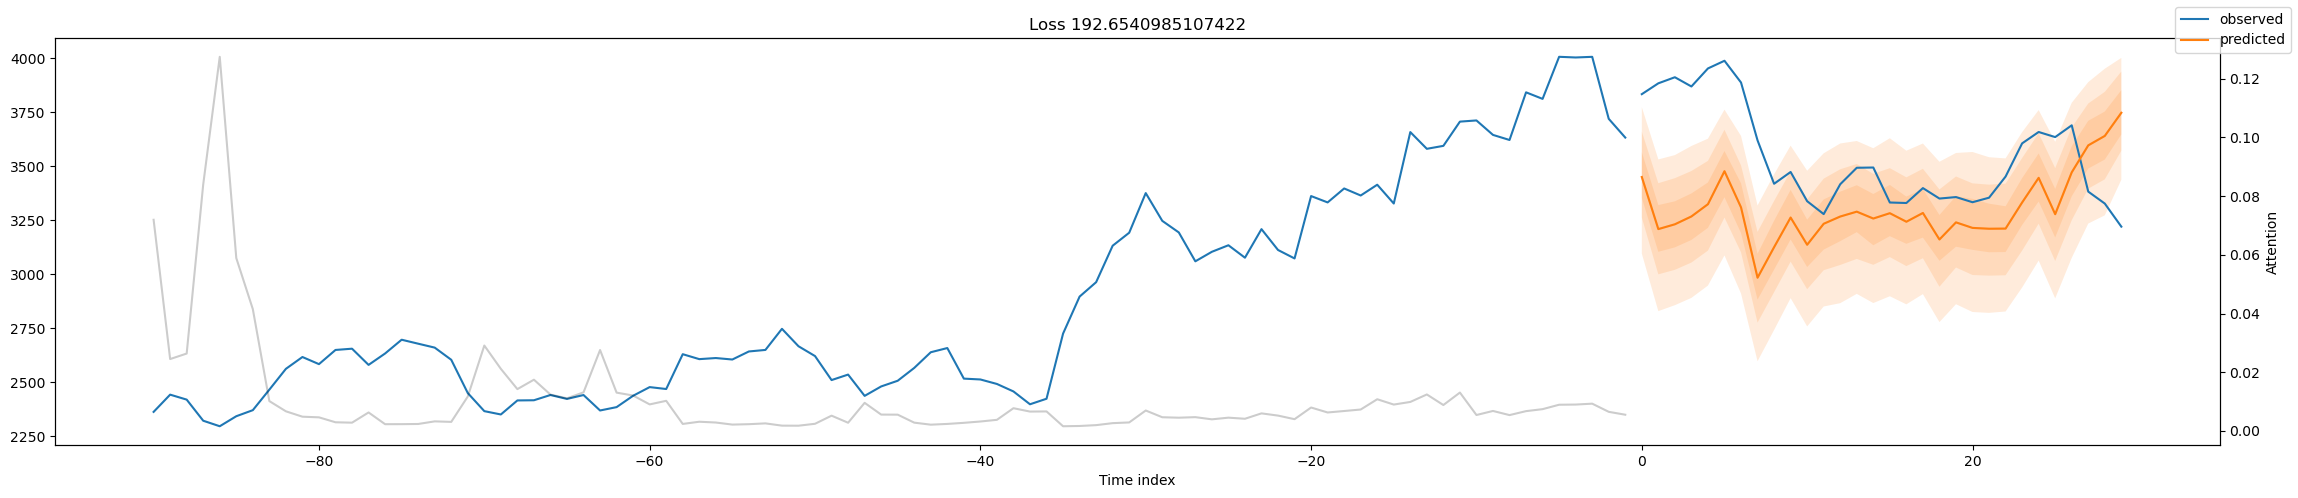

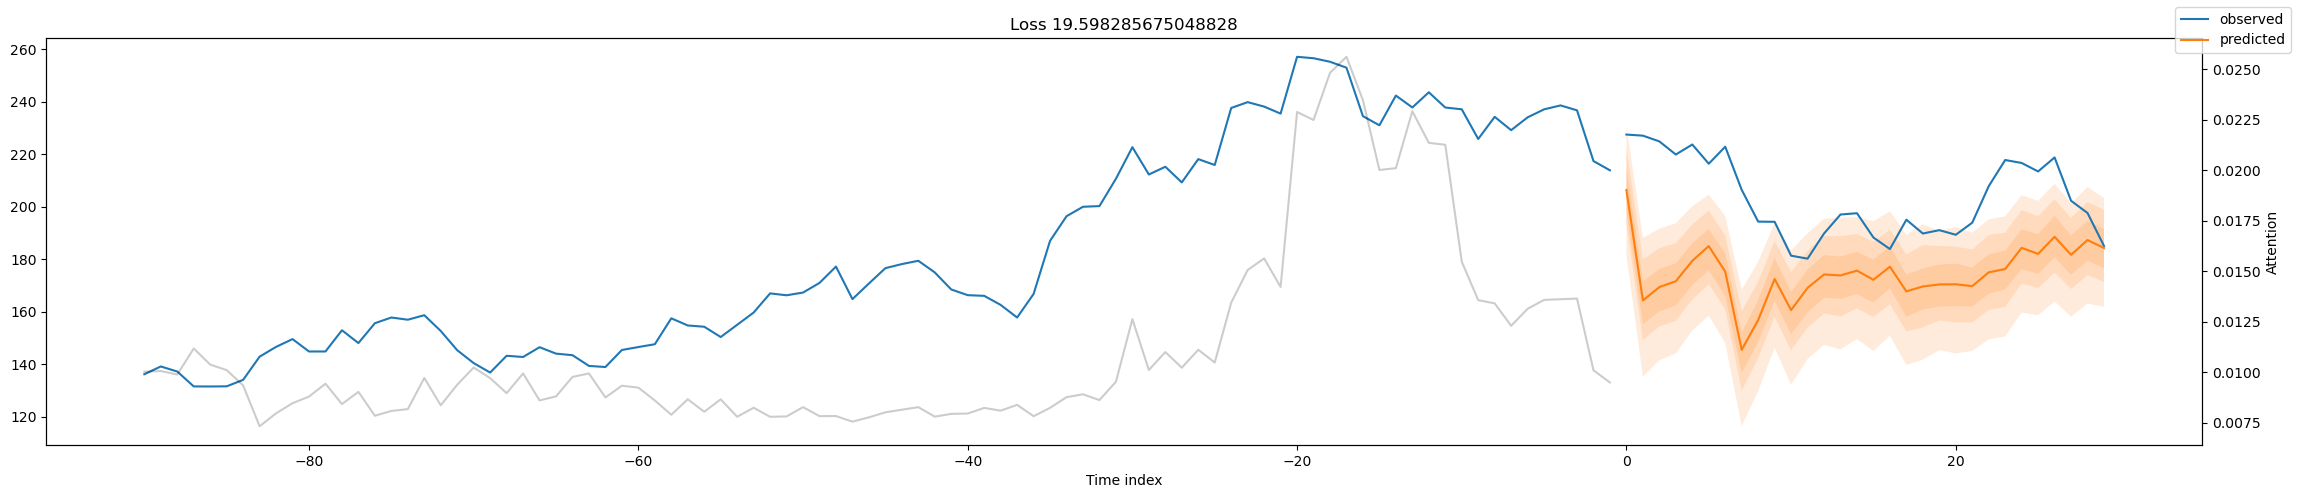

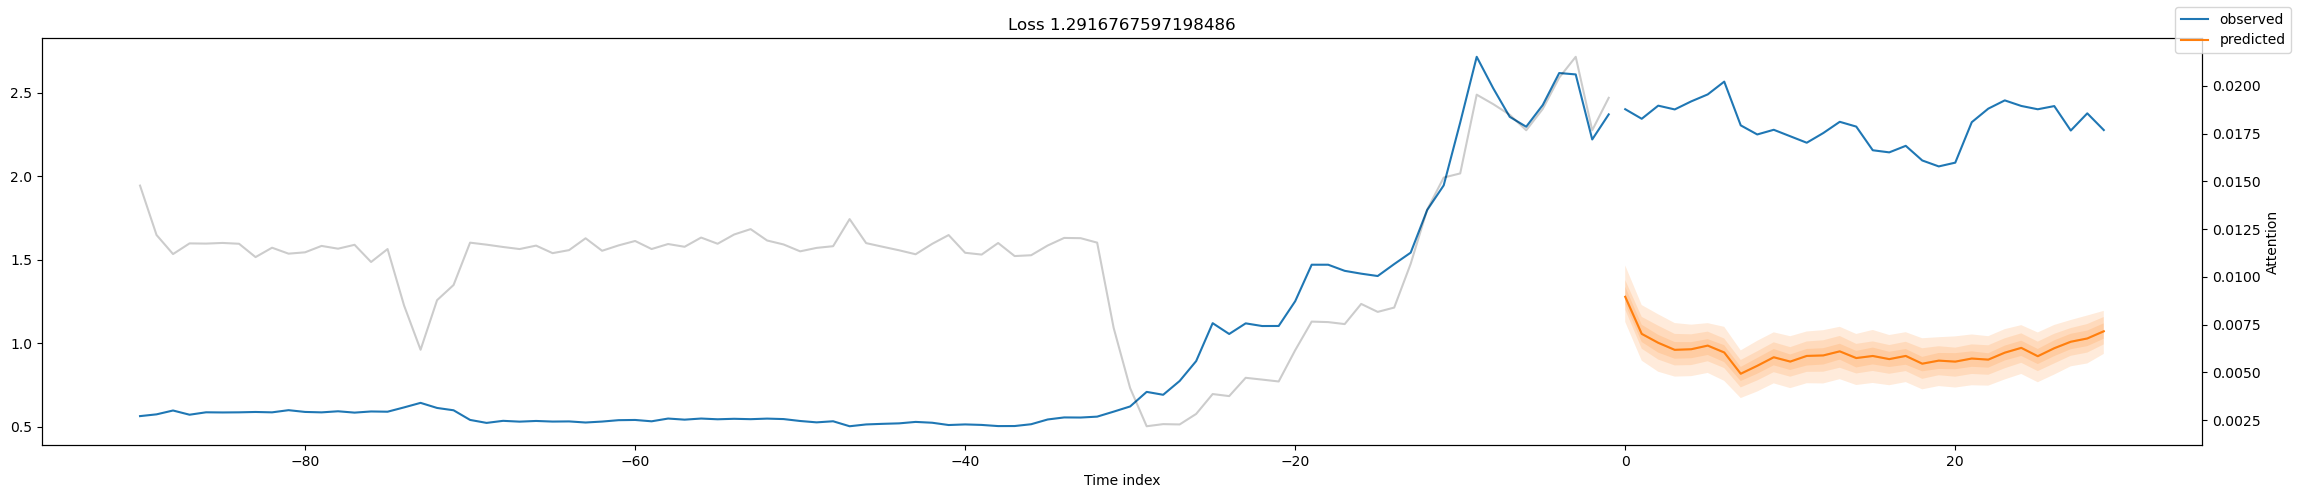

In [28]:
# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(4):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


MAE for BTC: 4458.68212890625


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


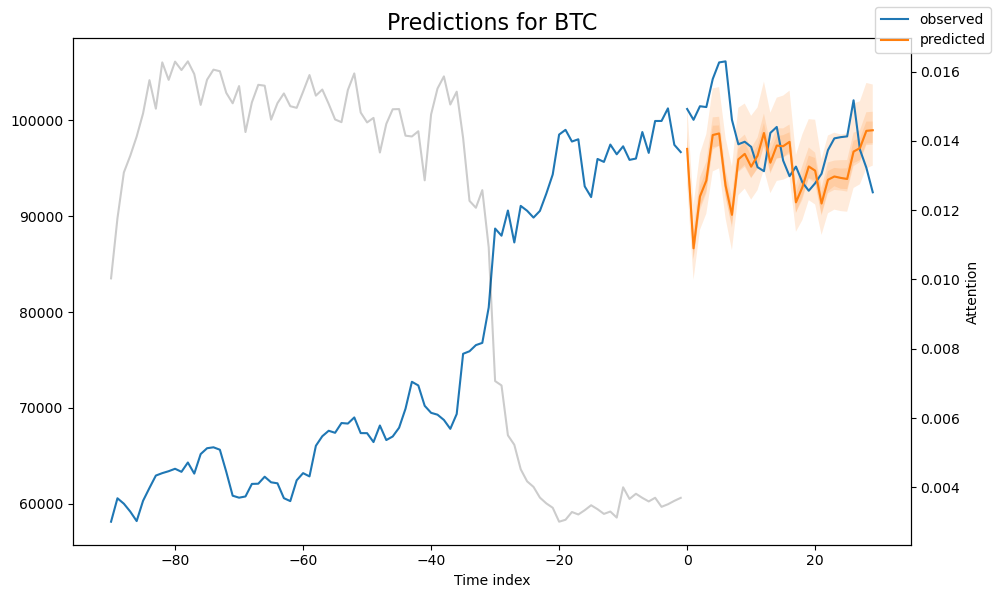

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


MAE for ETH: 307.0602722167969


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


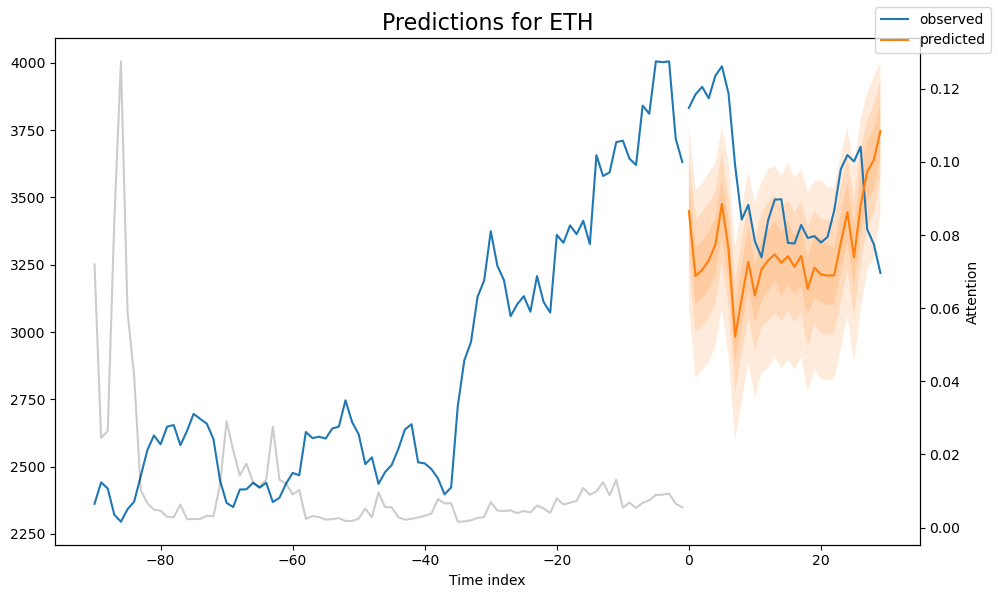

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


MAE for SOL: 28.588903427124023


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


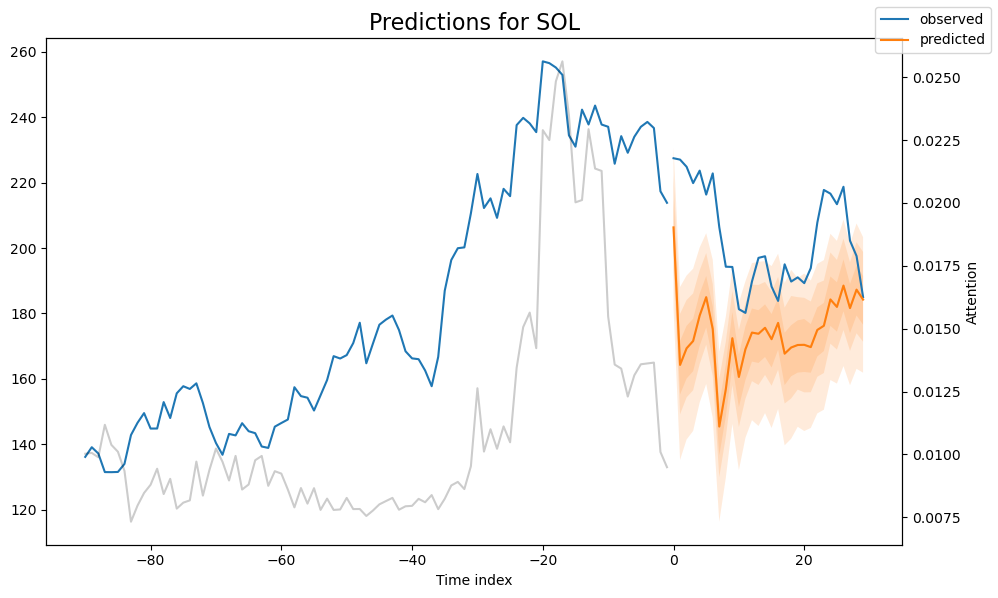

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


MAE for XRP: 1.3583400249481201


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


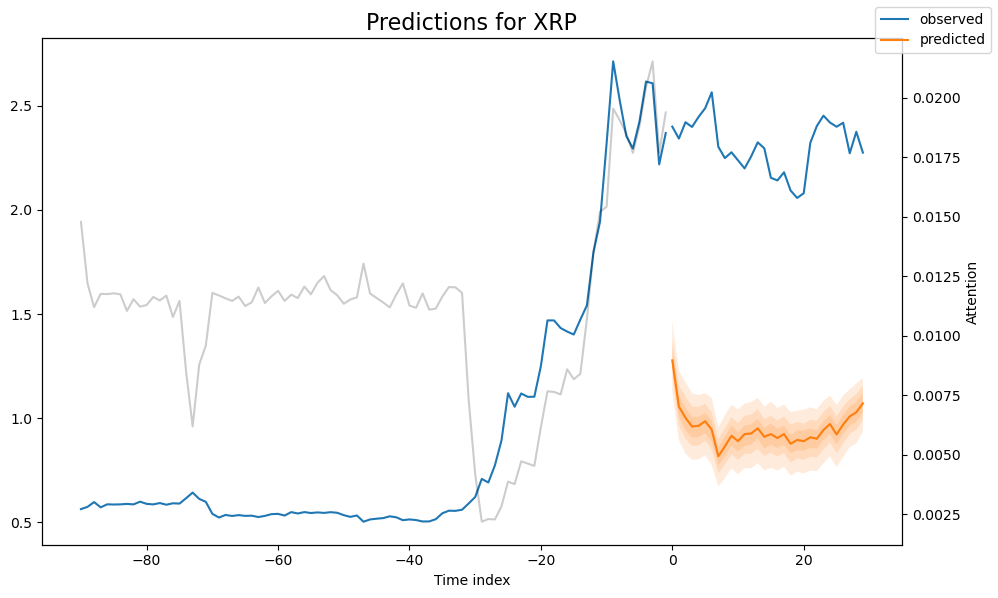

In [29]:
# Step 1: Get unique cryptocurrency types
cryptocurrencies = data['currency_type'].unique()

# Step 2: Loop over each cryptocurrency and make predictions
for crypto in cryptocurrencies:
    # Filter data for the current cryptocurrency
    crypto_data = data[data['currency_type'] == crypto]
    prediction_dates = crypto_data['Date'].tail(max_prediction_length).values
    # Step 3: Create a DataLoader for the filtered cryptocurrency data
    crypto_val_dataloader = TimeSeriesDataSet.from_dataset(training, crypto_data, predict=True, stop_randomization=True).to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # Step 4: Make predictions for the current cryptocurrency
    predictions = best_tft.predict(crypto_val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

    # Optionally, you can evaluate the predictions or plot them for each cryptocurrency
    # Evaluate MAE for this cryptocurrency (or any other metric)
    mae = MAE()(predictions.output, predictions.y)
    print(f"MAE for {crypto}: {mae.item()}")

    # Plot predictions for the first 10 samples (or any number you like)
    raw_predictions = best_tft.predict(crypto_val_dataloader, mode="raw", return_x=True)

    # Loop over the first 10 prediction samples
    for idx in range(min(10, raw_predictions.output.prediction.size(0))):  # Only plot available samples
        # Generate the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, ax=ax)

        # Set custom title for the plot
        plot_title = f"Predictions for {crypto}"
        ax.set_title(plot_title, fontsize=16)

        # Show the plot
        plt.show()
